In [8]:
#All imports
import operator
from scipy import linalg
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,mean_squared_error,accuracy_score,classification_report
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import mixture
import itertools
from scipy.stats import kurtosis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.linalg import pinv
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import homogeneity_score

from sklearn.model_selection import GridSearchCV

In [9]:
#import dataset
churn_model_df = pd.read_csv("Churn_Modelling.csv")

#drop unnecessary columns
churn_model_df.drop(["RowNumber", "CustomerId", "Surname"], 
                    axis = 1,
                    inplace = True)

In [10]:
def use_standard_scaler(columns, df):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def use_normalizer(columns,df):
    scaler = Normalizer()
    df[columns] = scaler.fit_transform(df[columns])
    return df


def perform_label_and_one_hot_encoding(onehotencoder,df):
    """
    Function to perform label and one hot encoding on given dataframe
    Performs on 2 columns: Gender, Geography
    """

    df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
    df['Geography'] = LabelEncoder().fit_transform(df['Geography'])

    gender_df = pd.DataFrame(onehotencoder.fit_transform(df[['Gender']]).toarray())
    gender_df.columns = ['Male','Female']

    geography_df = pd.DataFrame(onehotencoder.fit_transform(df[['Geography']]).toarray())
    geography_df.columns = ['France','Germany','Spain']

    df = df.join(gender_df)
    df = df.join(geography_df)

    df.drop(['Gender', 'Geography'],
                  axis = 1,
                  inplace = True)
    
    return df

def apply_elbow_method(data):
    km = KMeans(init = 'k-means++',
                n_init = 10,
                max_iter = 100,
                random_state = 42)

    visualizer = KElbowVisualizer(km,
                                  k=(1,10))

    visualizer.fit(data)       
    visualizer.show()  

def apply_silhouette_method(data):
    fig, ax = plt.subplots(3, 2, figsize=(15,8))

    for i in [2, 3, 4, 5, 6, 7]:

        km_cluster = KMeans(n_clusters = i,
                            init = 'k-means++',
                            n_init = 10,
                            max_iter = 100,
                            random_state = 42)

        q, mod = divmod(i, 2)

        cluster_labels = km_cluster.fit_predict(data)

        silhouette_avg = silhouette_score(data,
                                          cluster_labels)

        print(f"Clusters: {i} | silhouette_avg: {silhouette_avg}")

        visualizer = SilhouetteVisualizer(km_cluster,
                                          colors = 'yellowbrick',
                                          ax = ax[q-1][mod])
        visualizer.fit(data)

def find_best_param_gmm(data):
    
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 5)
    cv_types = ["spherical", "tied", "diag", "full"]

    for cv_type in cv_types:
        for n_components in n_components_range:

            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)

            gmm.fit(data)
            bic.append(gmm.bic(data))

            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(["blue", "green", "orange", "pink"])
    clf = best_gmm
    bars = []


    plt.figure(figsize=(10, 12))

    spl = plt.subplot(2, 1, 1)

    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + 0.2 * (i - 2)
        bars.append(
            plt.bar(xpos,
                    bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
                    width=0.2,
                    color=color))

    plt.xticks(n_components_range)

    plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])

    plt.title("BIC score per model")
    xpos = (
        np.mod(bic.argmin(), len(n_components_range))
        + 0.65
        + 0.2 * np.floor(bic.argmin() / len(n_components_range))
    )
    plt.text(xpos,
             bic.min() * 0.97 + 0.03 * bic.max(), 
             "*",
             fontsize=14)

    spl.set_xlabel("Number of components")
    spl.legend([b[0] for b in bars], cv_types)

In [11]:
churn_model_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [12]:
onehotencoder = OneHotEncoder(handle_unknown ='ignore')

data = perform_label_and_one_hot_encoding(onehotencoder,
                                          churn_model_df)

columns = ['EstimatedSalary','CreditScore', 'Age', 'Balance','Tenure','NumOfProducts']

data_scaled = use_standard_scaler(columns, data)

In [13]:
data_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Female,France,Germany,Spain
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,1,1,0.021886,1,1.0,0.0,1.0,0.0,0.0
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0,1,0.216534,0,1.0,0.0,0.0,0.0,1.0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,1,0,0.240687,1,1.0,0.0,1.0,0.0,0.0
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,0,0,-0.108918,0,1.0,0.0,1.0,0.0,0.0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,1,1,-0.365276,0,1.0,0.0,0.0,0.0,1.0


In [14]:
y = data_scaled['Exited']
X = data_scaled.drop('Exited', 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_7312\1767181148.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = data_scaled.drop('Exited', 1)


# K-means clustering

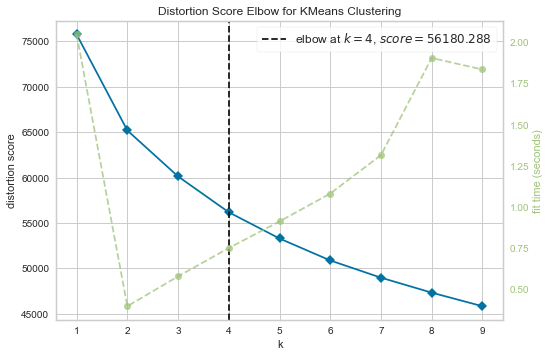

In [8]:
apply_elbow_method(X)

Clusters: 2 | silhouette_avg: 0.14416430136467415
Clusters: 3 | silhouette_avg: 0.1297137807872249
Clusters: 4 | silhouette_avg: 0.13129410317524484
Clusters: 5 | silhouette_avg: 0.11932012697876716
Clusters: 6 | silhouette_avg: 0.10781236482396656
Clusters: 7 | silhouette_avg: 0.10333297378762778


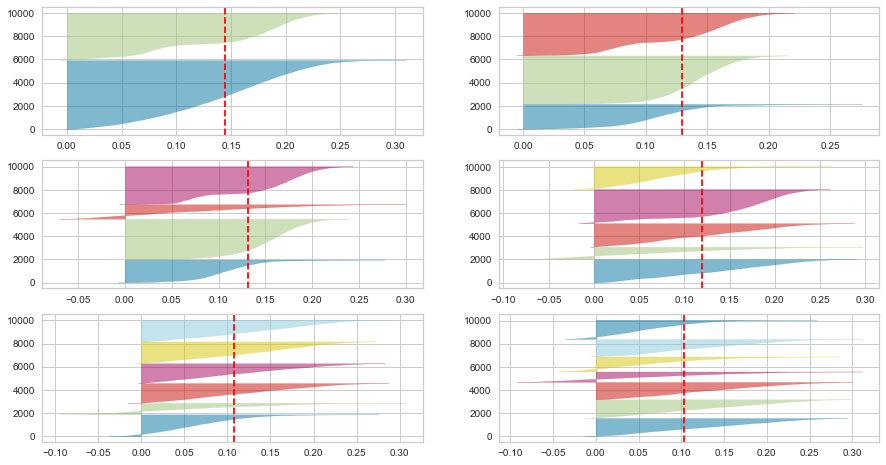

In [9]:
apply_silhouette_method(X)

In [15]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 60129.256017164254
Silhouette score: 0.1297137807872249


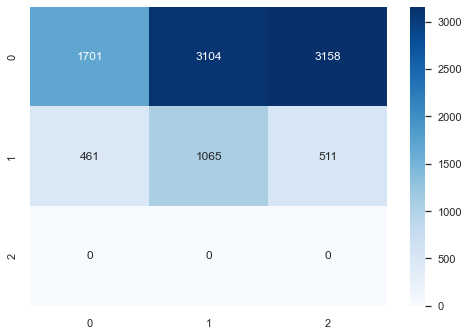

In [16]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [17]:
print(completeness_score(list(y), list(km_cluster.labels_)))
print(homogeneity_score(list(y), list(km_cluster.labels_)))

0.00794577641424506
0.016721056386314638


# Gaussian Mixture Model

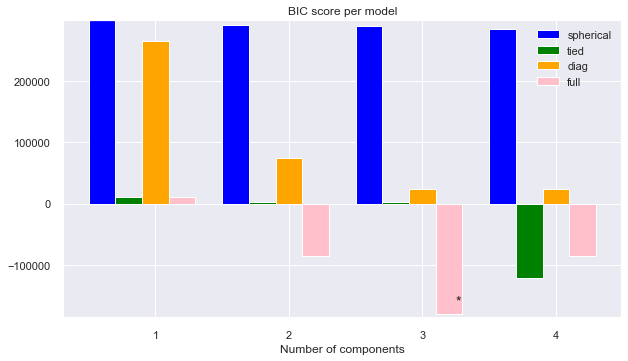

In [18]:
find_best_param_gmm(X)

In [19]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'full')
gmm.fit(X)
gmm_labels = gmm.predict(X)

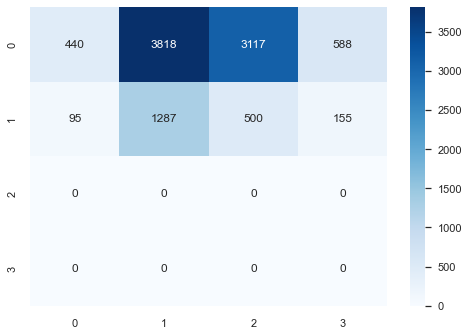

In [20]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [22]:
print(completeness_score(list(y), list(gmm_labels)))
print(homogeneity_score(list(y), list(gmm_labels)))

0.00834987298746857
0.017523959032211486


# PCA

In [23]:
pca = PCA().fit(X)

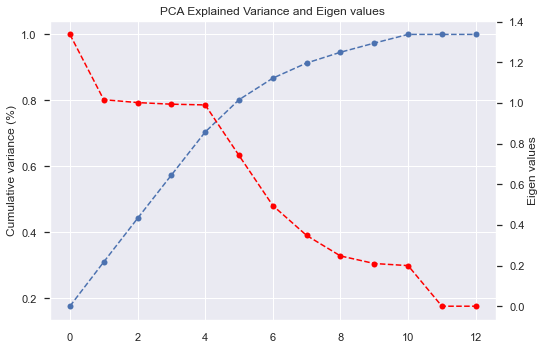

In [24]:
plt.figsize = (9,6)
fig, ax1 = plt.subplots()

x_axis1 = list(range(len(pca.explained_variance_ratio_)))
y_axis1 = np.cumsum(pca.explained_variance_ratio_)

x_axis2 = list(range(len(pca.explained_variance_)))
y_axis2 =  pca.explained_variance_

ax1.plot(x_axis1,
         y_axis1,
         marker='o',
         linestyle='--')
ax1.set_ylabel('Cumulative variance (%)')

ax2 = ax1.twinx()
ax2.plot(x_axis2,
         y_axis2,
         marker='o',
         linestyle='--',
         color = 'red')
ax2.set_ylabel('Eigen values')

plt.grid(False)
plt.xlabel('Principal Components')
plt.title('PCA Explained Variance and Eigen values')
plt.show()

In [29]:
X_PCA = PCA(7).fit_transform(X)
# X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA,
#                                                                     y,
#                                                                     test_size = 0.2,
#                                                                     random_state = 42)

# K-means after PCA

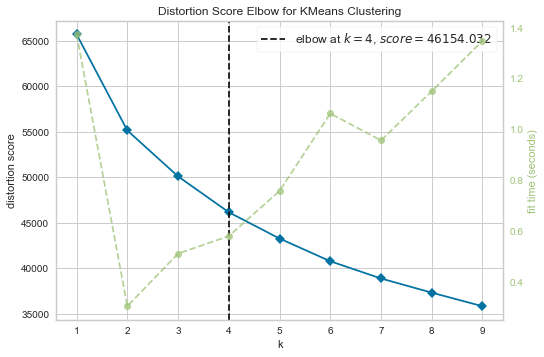

In [22]:
apply_elbow_method(X_PCA)

Clusters: 2 | silhouette_avg: 0.169062254232254
Clusters: 3 | silhouette_avg: 0.15343917563015816
Clusters: 4 | silhouette_avg: 0.15659043961209831
Clusters: 5 | silhouette_avg: 0.14430616683070563
Clusters: 6 | silhouette_avg: 0.13518277448211125
Clusters: 7 | silhouette_avg: 0.12875704157310347


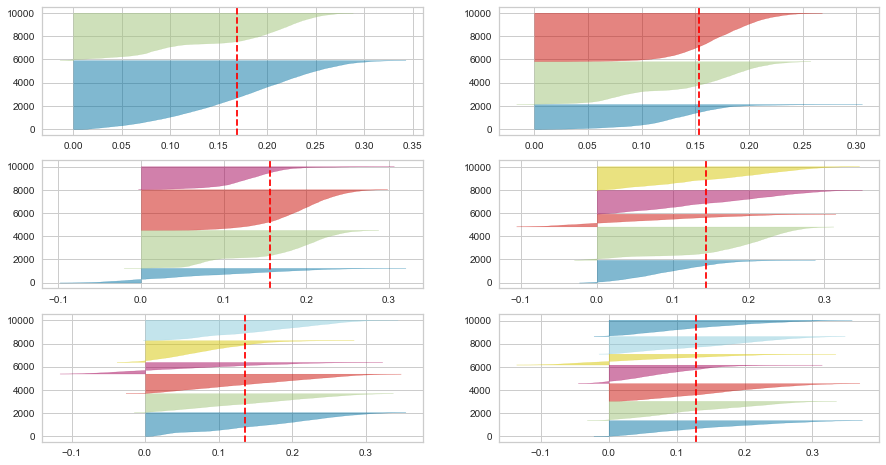

In [23]:
apply_silhouette_method(X_PCA)

In [24]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_PCA)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_PCA, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 50102.19576175061
Silhouette score: 0.15343917563015816


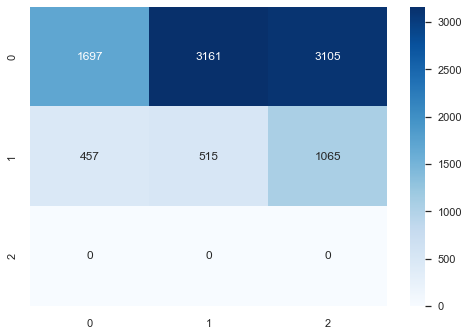

In [25]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [26]:
print(completeness_score(list(y), list(km_cluster.labels_)))
print(homogeneity_score(list(y), list(km_cluster.labels_)))

0.007810650712042333
0.016429929931123376


In [27]:
km_pca_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after PCA

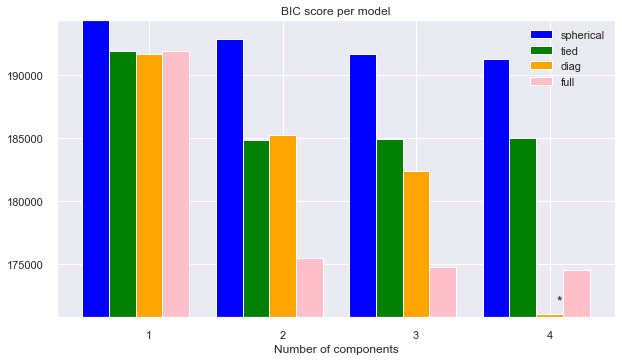

In [86]:
find_best_param_gmm(X_PCA)

In [28]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'diag')
gmm.fit(X_PCA)
gmm_labels = gmm.predict(X_PCA)

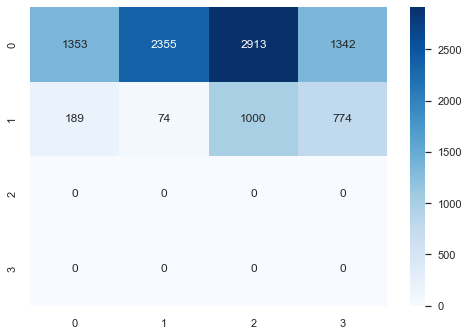

In [29]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [30]:
print(completeness_score(list(y), list(gmm_labels)))
print(homogeneity_score(list(y), list(gmm_labels)))

0.040407924888188604
0.1061406718250367


In [31]:
gmm_pca_labels = list(gmm_labels)

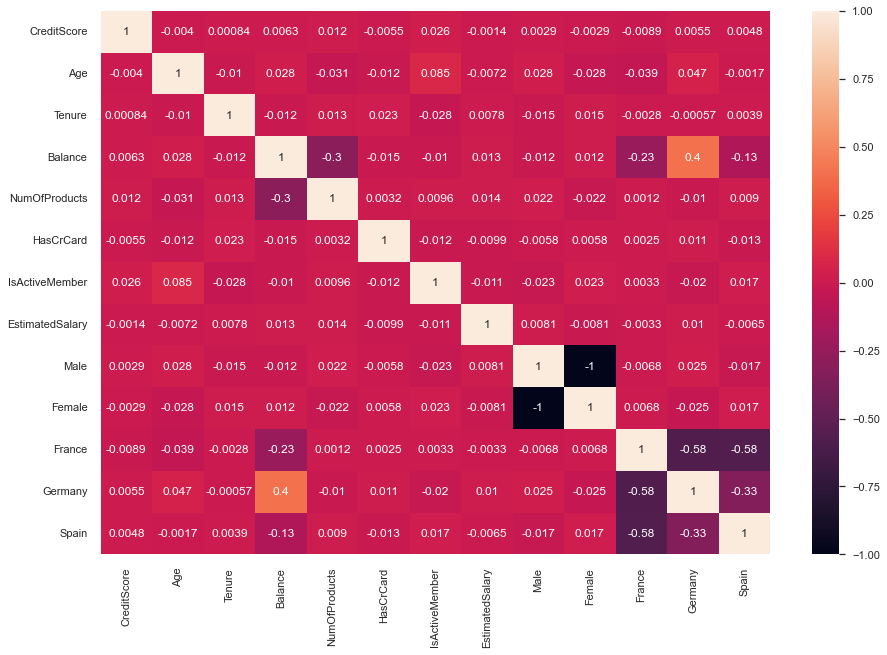

In [27]:
corrMatrix = X.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

# ICA

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\decomposition\_fastica.py:468: UserWarning: n_components is too large: it will be set to 13
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


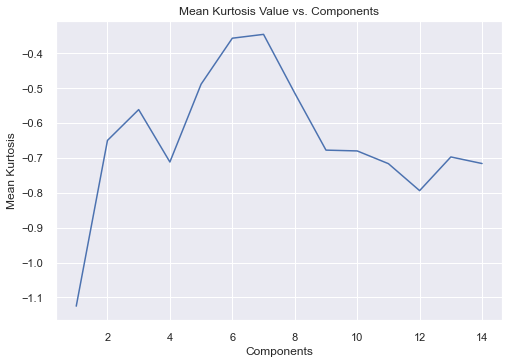

In [34]:
kurtosis_values = []
for i in range(1,15):
    X_ICA = FastICA(n_components = i).fit_transform(X)
    kur = kurtosis(X_ICA)
    kurtosis_values.append(np.mean(kur))
kurtosis_values = np.array(kurtosis_values)
plt.plot(np.arange(1,15),kurtosis_values)
plt.xlabel('Components')
plt.ylabel('Mean Kurtosis')
plt.title('Mean Kurtosis Value vs. Components')
plt.show()

In [35]:
np.argmax(kurtosis_values)+1

7

In [34]:
X_ICA = FastICA(n_components = 7).fit_transform(X)

# X_ICA_train,X_ICA_test, y_ICA_train, y_ICA_test = train_test_split(X_ICA,
#                                                                     y,
#                                                                     test_size = 0.2,
#                                                                     random_state = 42)

# K-means after ICA

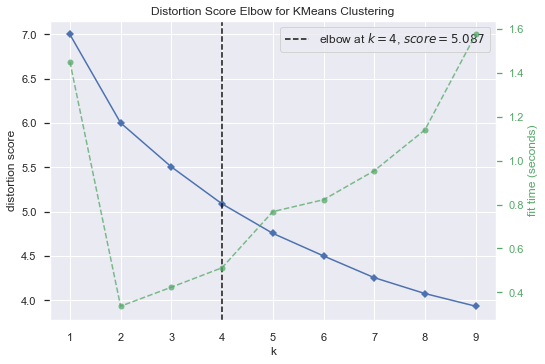

In [36]:
apply_elbow_method(X_ICA)

Clusters: 2 | silhouette_avg: 0.15383681732956933
Clusters: 3 | silhouette_avg: 0.1389861779363879
Clusters: 4 | silhouette_avg: 0.14798245086031078
Clusters: 5 | silhouette_avg: 0.15344917827938329
Clusters: 6 | silhouette_avg: 0.14885851986700827
Clusters: 7 | silhouette_avg: 0.14994759426561935


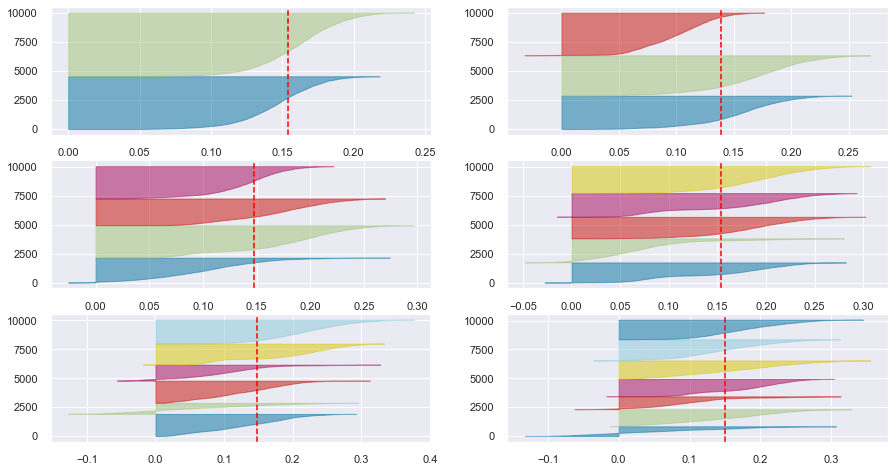

In [92]:
apply_silhouette_method(X_ICA)

In [33]:
k  = 4
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_ICA)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_ICA, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 5.086649205856516
Silhouette score: 0.14798245086031125


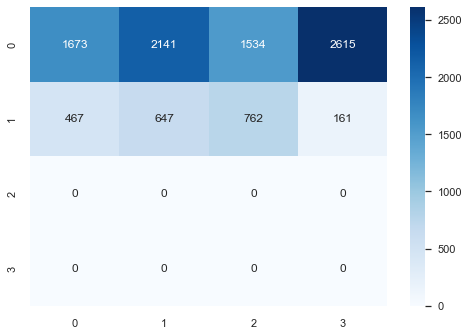

In [34]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [35]:
print(completeness_score(list(y), list(km_cluster.labels_)))
print(homogeneity_score(list(y), list(km_cluster.labels_)))

0.025218838785275123
0.06883036308630415


In [36]:
km_ica_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after ICA

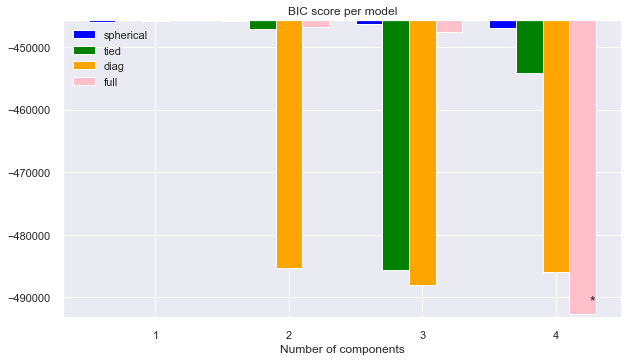

In [101]:
find_best_param_gmm(X_ICA)

In [37]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'full')
gmm.fit(X_ICA)
gmm_labels = gmm.predict(X_ICA)

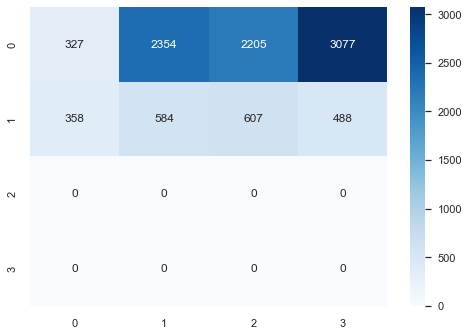

In [38]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [39]:
print(completeness_score(list(y), list(gmm_labels)))
print(homogeneity_score(list(y), list(gmm_labels)))

0.017777873330884982
0.04459380208700273


In [40]:
gmm_ica_labels = list(gmm_labels)

# GaussianRandomProjection

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: 

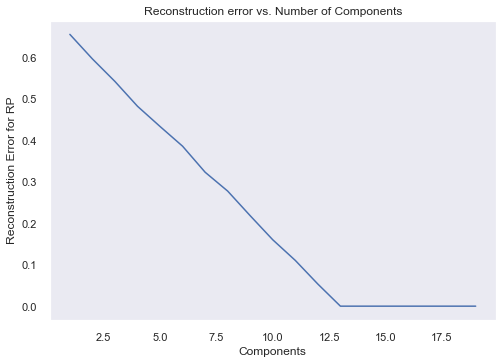

In [51]:
reconstruction_error = []

for i in range(1,20):
    mean_mse = []
    
    for j in range(0,20):
        
        X_RP = GaussianRandomProjection(n_components=i).fit(X)
        
        w = X_RP.components_
        p = pinv(w)

        mean_mse.append(mean_squared_error(X,((p@w)@(X.T)).T))
        
    reconstruction_error.append(np.mean(mean_mse))

reconstruction_error = np.array(reconstruction_error)
plt.plot(np.arange(1,20),reconstruction_error)

plt.xlabel('Components')
plt.ylabel('Reconstruction Error for RP')
plt.title('Reconstruction error vs. Number of Components')
plt.grid()
plt.show()

In [37]:
X_RP = GaussianRandomProjection(n_components = 5).fit_transform(X)
# X_RP_train, X_RP_test, y_RP_train, y_RP_test = train_test_split(X_RP, y, test_size=0.2, random_state=42)

# K-means after GaussianRandomProjection

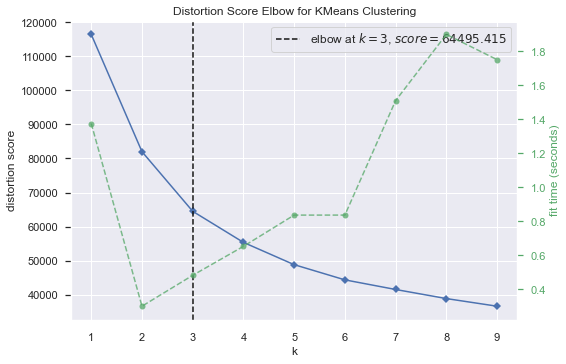

In [108]:
apply_elbow_method(X_RP)

Clusters: 2 | silhouette_avg: 0.26545848662447386
Clusters: 3 | silhouette_avg: 0.26517843821413
Clusters: 4 | silhouette_avg: 0.2229280548104182
Clusters: 5 | silhouette_avg: 0.23136283539298974
Clusters: 6 | silhouette_avg: 0.22908460846667614
Clusters: 7 | silhouette_avg: 0.22456699520331858


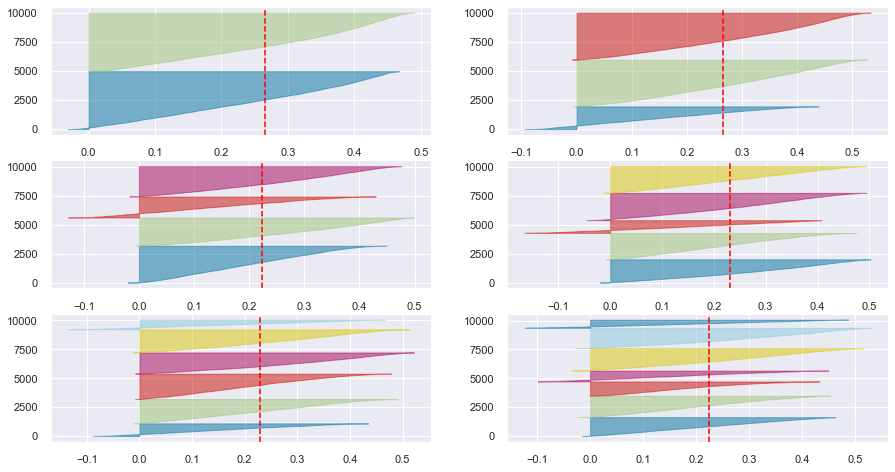

In [109]:
apply_silhouette_method(X_RP)

In [44]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_RP)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_RP, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 51955.4083266317
Silhouette score: 0.19417448778064633


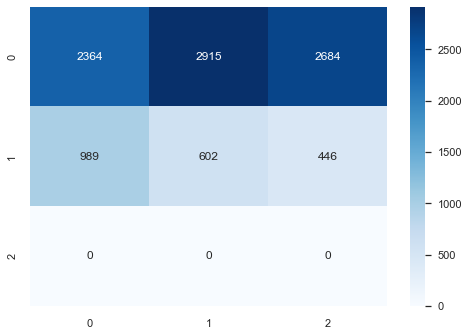

In [45]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [46]:
print(completeness_score(list(y), list(km_cluster.labels_)))
print(homogeneity_score(list(y), list(km_cluster.labels_)))

0.011819814693155833
0.025662208304197135


In [47]:
km_grp_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after GaussianRandomProjection

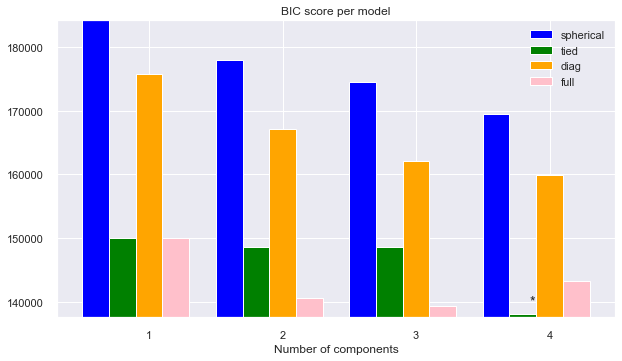

In [114]:
find_best_param_gmm(X_RP)

In [48]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'tied')
gmm.fit(X_RP)
gmm_labels = gmm.predict(X_RP)

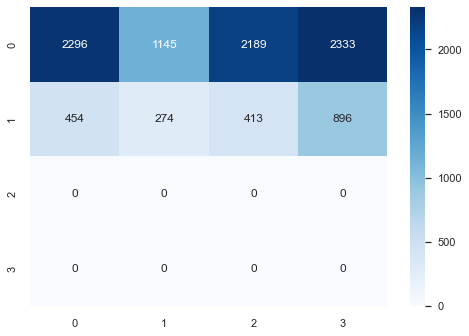

In [49]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [50]:
print(completeness_score(list(y), list(gmm_labels)))
print(homogeneity_score(list(y), list(gmm_labels)))

0.00602251310907431
0.016053445653715588


In [51]:
gmm_grp_labels = list(gmm_labels)

# ExtraTreesClassifier

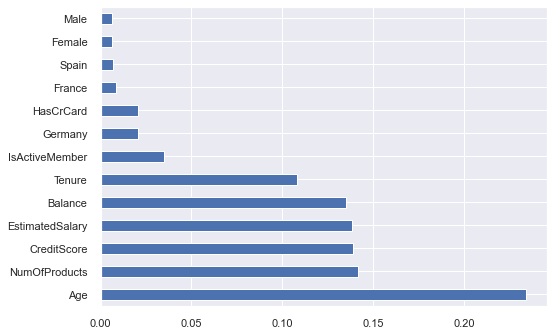

In [125]:
model = ExtraTreesClassifier()
model.fit(X,y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [52]:
X_feat = X[['Age','NumOfProducts','CreditScore','EstimatedSalary','Balance','Tenure']]

# K-means after Feature Selection

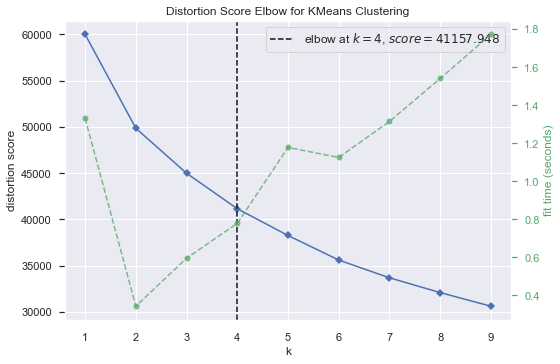

In [129]:
apply_elbow_method(X_feat)

Clusters: 2 | silhouette_avg: 0.178619214145994
Clusters: 3 | silhouette_avg: 0.16603881243725474
Clusters: 4 | silhouette_avg: 0.14987550716367176
Clusters: 5 | silhouette_avg: 0.14546866356359273
Clusters: 6 | silhouette_avg: 0.15172784464281316
Clusters: 7 | silhouette_avg: 0.14689986837904695


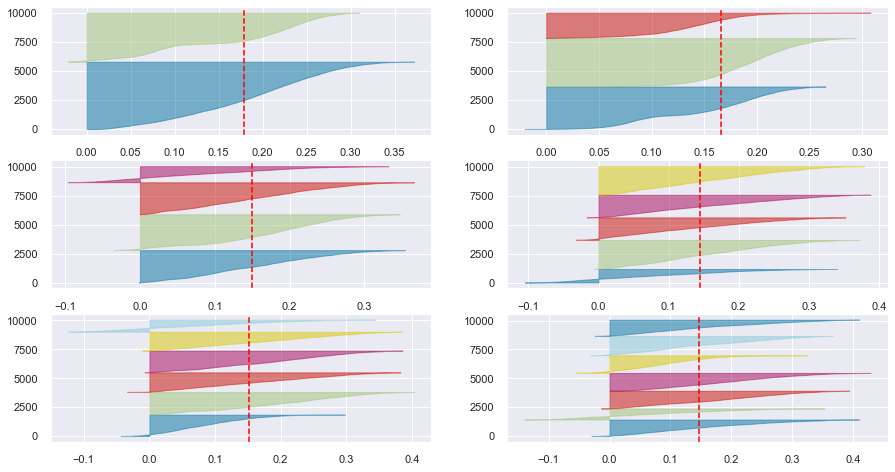

In [130]:
apply_silhouette_method(X_feat)

In [53]:
k = 3
km_cluster = KMeans(n_clusters = k,
                    init = 'k-means++',
                    n_init = 10,
                    max_iter = 100,
                    random_state = 42)

km_cluster.fit(X_feat)

print(f'Inertia: {km_cluster.inertia_}')

silhouette_score_value = silhouette_score(X_feat, km_cluster.labels_)

print(f'Silhouette score: {silhouette_score_value}')

Inertia: 44998.073676636224
Silhouette score: 0.16603881243725474


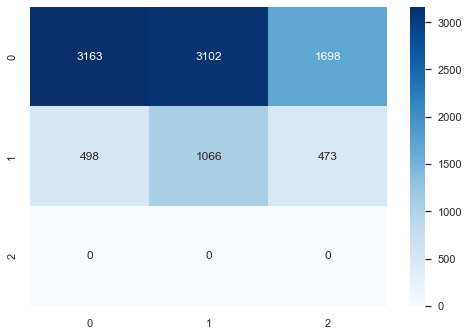

In [54]:
cm = confusion_matrix(list(y), list(km_cluster.labels_))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [55]:
km_fs_labels = list(km_cluster.labels_)

# Gaussian Mixture Model after Feature Selection

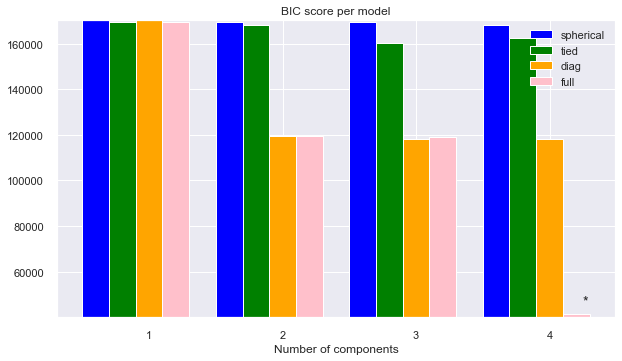

In [140]:
find_best_param_gmm(X_feat)

In [56]:
gmm = mixture.GaussianMixture(n_components = 4,
                              covariance_type = 'tied')
gmm.fit(X_feat)
gmm_labels = gmm.predict(X_feat)

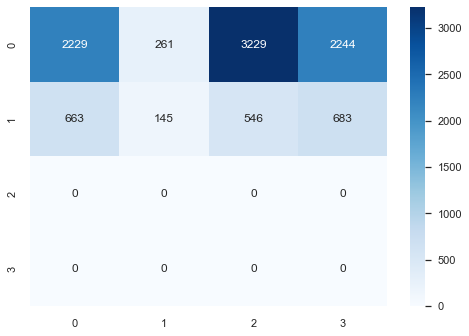

In [57]:
cm = confusion_matrix(list(y), list(gmm_labels))
sns.set()
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

In [58]:
gmm_fs_labels = list(gmm_labels)

# DR on this dataset, but using train-test split for running NN

In [8]:
"""
Split data in train and test set before performing data visualizations
80% training and 20% testing
"""
train_df, test_df = train_test_split(churn_model_df,
                                     test_size = 0.2,
                                     random_state = 42)

train_df.reset_index(drop = True,
                     inplace = True)
test_df.reset_index(drop = True,
                    inplace = True)

print("Training set: {}".format(train_df.shape))
print("Testing set: {}".format(test_df.shape))

onehotencoder = OneHotEncoder(handle_unknown ='ignore')
train_df = perform_label_and_one_hot_encoding(onehotencoder,train_df)
test_df = perform_label_and_one_hot_encoding(onehotencoder,test_df)



columns = ['EstimatedSalary','CreditScore', 'Age', 'Balance','Tenure','NumOfProducts']

train_df = use_standard_scaler(columns, train_df)
test_df = use_standard_scaler(columns, test_df)


y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)


Training set: (8000, 11)
Testing set: (2000, 11)


C:\Users\Hp\AppData\Local\Temp\ipykernel_17432\2190669668.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
C:\Users\Hp\AppData\Local\Temp\ipykernel_17432\2190669668.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Geography'] = LabelEncoder().fit_transform(df['Geography'])
C:\Users\Hp\AppData\Local\Temp\ipykernel_17432\2190669668.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [9]:
pca = PCA(7)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)



ica = FastICA(n_components = 11)
ica.fit(X_train)
X_train_ICA = ica.transform(X_train)
X_test_ICA = ica.transform(X_test)


grp = GaussianRandomProjection(n_components = 5)
grp.fit(X_train)
X_train_GRP = grp.transform(X_train)
X_test_GRP = grp.transform(X_test)


X_train_feat = X_train[['Age','NumOfProducts','CreditScore',
                        'EstimatedSalary','Balance','Tenure']]
X_test_feat = X_test[['Age','NumOfProducts','CreditScore',
                        'EstimatedSalary','Balance','Tenure']]

In [10]:
#******************DEFINING FUNCTIONS*****************

def run_basic_nn(train_input,
                  train_output,
                  test_input,
                  test_output):

    
    clf = MLPClassifier()

    model = clf.fit(train_input, train_output)
    
    test_predictions = model.predict(test_input)
    train_prediction = model.predict(train_input)

    print(f'Initial Train score {accuracy_score(train_output,train_prediction)}')
    print(f'Initial Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))


def find_best_activation_func(train_input,
                              train_output,
                              test_input,
                              test_output):
    
    activ_func = {}
    activation_funcs= ['identity','logistic','tanh','relu']
    for i in activation_funcs:

        clf = MLPClassifier(activation = i)
        clf.fit(train_input, train_output)
        test_predictions = clf.predict(test_input)
        activ_func[i] = accuracy_score(test_output, test_predictions)


    activ_func = dict(sorted(activ_func.items(), key=operator.itemgetter(1),reverse=True))
    print(activ_func)

    activ_funcs = list(activ_func.keys())
    accuracy = list(activ_func.values())

    fig = plt.figure(figsize = (5, 3.5))

    plt.bar(activ_funcs,accuracy, color ='red',width = 0.4)

    plt.xlabel("Activation function")
    plt.ylabel("Accuracy")
    plt.title("Activation function VS accuries")
    plt.show()
    
def select_best_parameters_nn(train_input, train_output,
                             hidden_layer_sizes,activation):


    param_grid = {'hidden_layer_sizes': hidden_layer_sizes,
                  'activation': activation}

    boost = GridSearchCV(estimator = MLPClassifier(), param_grid=param_grid, cv=10)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)

def best_model_nn(train_input,
                   train_output,
                   test_input,
                   test_output,
                   hidden_layer_sizes,
                   activation):
    
    clf = MLPClassifier(hidden_layer_sizes =  hidden_layer_sizes,
                        activation = activation)
    
    clf.fit(train_input, train_output)

    test_predictions = clf.predict(test_input)
    train_predictions = clf.predict(train_input)

    print(f'Train score {accuracy_score(train_output,train_predictions)}')
    print(f'Test score {accuracy_score(test_output,test_predictions)}')

    print(classification_report(test_output, test_predictions))
    return confusion_matrix(test_output,test_predictions,labels=[0,1])

def find_best_hidden_layers_size(train_input,
                                 train_output,
                                 test_input,
                                 test_output,
                                 hidden_layer_sizes_li):
    
    hidden_layer_sizes_li = hidden_layer_sizes_li
    
    accuracy_test = []
    accuracy_train = []

    for i in hidden_layer_sizes_li:    
        
        clf = MLPClassifier(hidden_layer_sizes=(i,), activation='logistic', )
        clf.fit(train_input, train_output)
        
        predictions_test = clf.predict(test_input)
        predictions_train = clf.predict(train_input)
        
        accuracy_test.append(accuracy_score(test_output, predictions_test))
        accuracy_train.append(accuracy_score(train_output, predictions_train))
      
    plt.plot(hidden_layer_sizes_li, accuracy_test, 'o-', color='red', label='Test Score')
    plt.plot(hidden_layer_sizes_li, accuracy_train, 'o-', color = 'blue', label='Train Score')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Hidden Units')
    
    plt.title("Validation curve")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'tanh': 0.8505, 'logistic': 0.8475, 'relu': 0.8475, 'identity': 0.794}


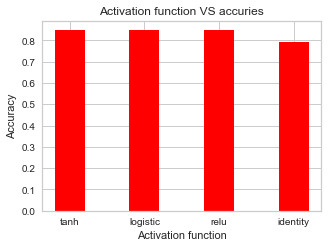

{'relu': 0.8315, 'logistic': 0.8165, 'identity': 0.8115, 'tanh': 0.811}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


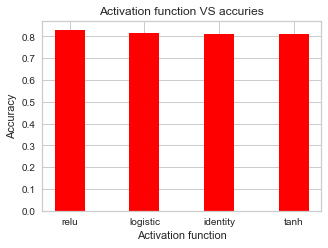

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'tanh': 0.8605, 'relu': 0.857, 'logistic': 0.8565, 'identity': 0.807}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


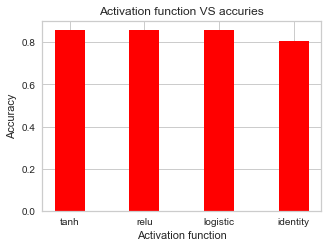

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'relu': 0.8525, 'tanh': 0.8475, 'logistic': 0.8435, 'identity': 0.789}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


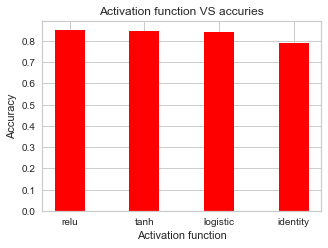

In [11]:
from sklearn.neural_network import MLPClassifier


find_best_activation_func(X_train_PCA, y_train, X_test_PCA, y_test)
find_best_activation_func(X_train_ICA, y_train, X_test_ICA, y_test)
find_best_activation_func(X_train_GRP, y_train, X_test_GRP, y_test)
find_best_activation_func(X_train_feat, y_train, X_test_feat, y_test)

In [12]:
hidden_layer_sizes = [60,70,80,90,100,110,120,130,140,150]
activation = ['tanh','relu']

select_best_parameters_nn(X_train_PCA, y_train, hidden_layer_sizes,activation)
select_best_parameters_nn(X_train_ICA, y_train, hidden_layer_sizes,activation)
select_best_parameters_nn(X_train_GRP, y_train, hidden_layer_sizes,activation)
select_best_parameters_nn(X_train_feat, y_train, hidden_layer_sizes,activation)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

Per Hyperparameter tuning, best parameters are:
{'activation': 'relu', 'hidden_layer_sizes': 80}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
best_model_nn(X_train_PCA,y_train,X_test_PCA,y_test,80,'relu')
best_model_nn(X_train_ICA,y_train,X_test_ICA,y_test,120,'relu')
best_model_nn(X_train_GRP,y_train,X_test_GRP,y_test,100,'tanh')
best_model_nn(X_train_feat,y_train,X_test_feat,y_test,80,'tanh')

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train score 0.8535
Test score 0.8455
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1607
           1       0.65      0.46      0.54       393

    accuracy                           0.85      2000
   macro avg       0.76      0.70      0.72      2000
weighted avg       0.83      0.85      0.83      2000



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train score 0.840125
Test score 0.8385
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1607
           1       0.70      0.32      0.43       393

    accuracy                           0.84      2000
   macro avg       0.77      0.64      0.67      2000
weighted avg       0.82      0.84      0.81      2000

Train score 0.857875
Test score 0.862
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1607
           1       0.71      0.50      0.59       393

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.75      2000
weighted avg       0.85      0.86      0.85      2000

Train score 0.84375
Test score 0.846
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1607
           1       0.68      0.41      0.51       393

    accuracy                           0.85      2000
   macro avg  

array([[1531,   76],
       [ 232,  161]], dtype=int64)

# Using clustering results as features on original data and running NN

In [60]:
# km_pca_labels
# gmm_pca_labels

# km_ica_labels
# gmm_ica_labels

# km_grp_labels
# gmm_grp_labels

# km_fs_labels
# gmm_fs_labels

In [73]:
def hot_encode_clusters(df,labels_df):

    df1 = pd.DataFrame(onehotencoder.fit_transform(labels_df[['labels']]).toarray())

    df = df.join(df1)
#     print(df)

#     df.drop(['labels'],axis = 1,inplace = True)
    
    return df

In [81]:
def split_train_test(data):
    train_df, test_df = train_test_split(data,
                                 test_size = 0.2,
                                 random_state = 42)

    train_df.reset_index(drop = True,
                 inplace = True)
    test_df.reset_index(drop = True,
                inplace = True)
    y_train = train_df['Exited']
    X_train = train_df.drop('Exited', 1)

    y_test = test_df['Exited']
    X_test = test_df.drop('Exited', 1)
    
    return X_train, y_train, X_test, y_test

In [93]:
km_pca_labels_df = hot_encode_clusters(X,pd.DataFrame(km_pca_labels,columns = ['labels']))
gmm_pca_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_pca_labels,columns = ['labels']))

km_ica_labels_df = hot_encode_clusters(X,pd.DataFrame(km_ica_labels,columns = ['labels']))
gmm_ica_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_ica_labels,columns = ['labels']))

km_grp_labels_df = hot_encode_clusters(X,pd.DataFrame(km_grp_labels,columns = ['labels']))
gmm_grp_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_grp_labels,columns = ['labels']))

km_fs_labels_df = hot_encode_clusters(X,pd.DataFrame(km_fs_labels,columns = ['labels']))
gmm_fs_labels_df = hot_encode_clusters(X,pd.DataFrame(gmm_fs_labels,columns = ['labels']))

y_df = pd.DataFrame(y)

In [95]:
X_train, y_train, X_test, y_test = split_train_test(km_pca_labels_df.join(y_df))

C:\Users\Hp\AppData\Local\Temp\ipykernel_17432\1508897521.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train_df.drop('Exited', 1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_17432\1508897521.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = test_df.drop('Exited', 1)


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'tanh': 0.8635, 'logistic': 0.8625, 'relu': 0.861, 'identity': 0.812}


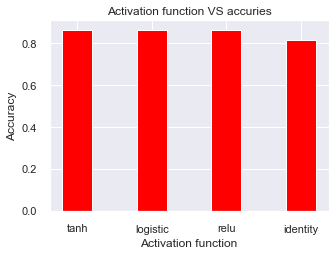

In [96]:
find_best_activation_func(X_train, y_train, X_test, y_test)
find_best_activation_func(X_train_ICA, y_train, X_test_ICA, y_test)
find_best_activation_func(X_train_GRP, y_train, X_test_GRP, y_test)
find_best_activation_func(X_train_feat, y_train, X_test_feat, y_test)

In [98]:
hidden_layer_sizes = [60,70,80,90,100,110,120,130,140,150]
activation = ['tanh','logistic']

select_best_parameters_nn(X_train, y_train, hidden_layer_sizes,activation)

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

Per Hyperparameter tuning, best parameters are:
{'activation': 'tanh', 'hidden_layer_sizes': 90}


C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [97]:
best_model_nn(X_train, y_train, X_test, y_test,80,'tanh')
# best_model_nn(X_train_ICA,y_train,X_test_ICA,y_test,120,'relu')
# best_model_nn(X_train_GRP,y_train,X_test_GRP,y_test,100,'tanh')
# best_model_nn(X_train_feat,y_train,X_test_feat,y_test,80,'tanh')

Train score 0.86875
Test score 0.8625
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1607
           1       0.70      0.53      0.60       393

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.86      2000



C:\Users\Hp\Anaconda2\envs\ml_assignment1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


array([[1517,   90],
       [ 185,  208]], dtype=int64)

In [41]:
# Code taken scikit-learn (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
import matplotlib
def display_clusters(X,k):

    range_n_clusters = np.arange(k, k+1, 1)
    
    for n_clusters in range_n_clusters:

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])

        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)


        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):

            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = matplotlib.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )


            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = matplotlib.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )


        centers = clusterer.cluster_centers_

        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

For n_clusters = 3 The average silhouette_score is : 0.13447769507006216


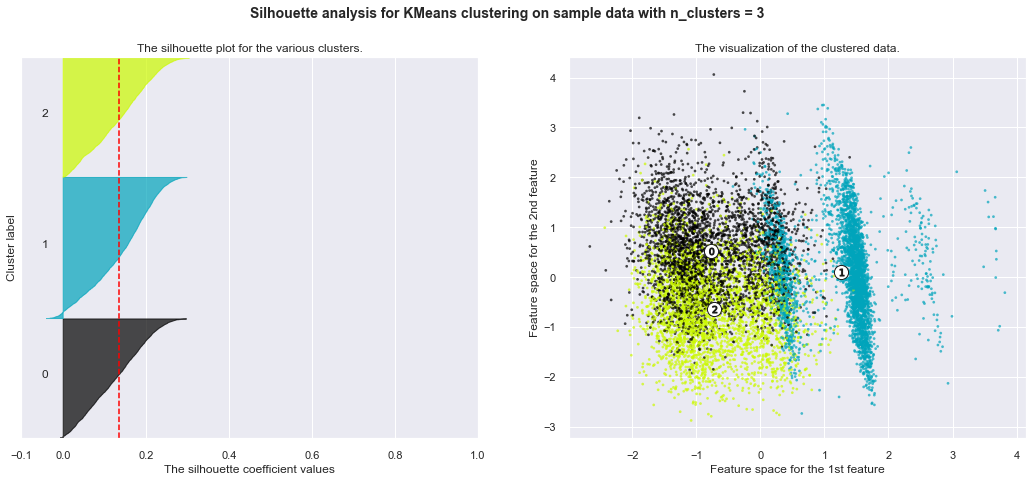

In [43]:
display_clusters(X_PCA,3)

For n_clusters = 4 The average silhouette_score is : 0.14797797683291355


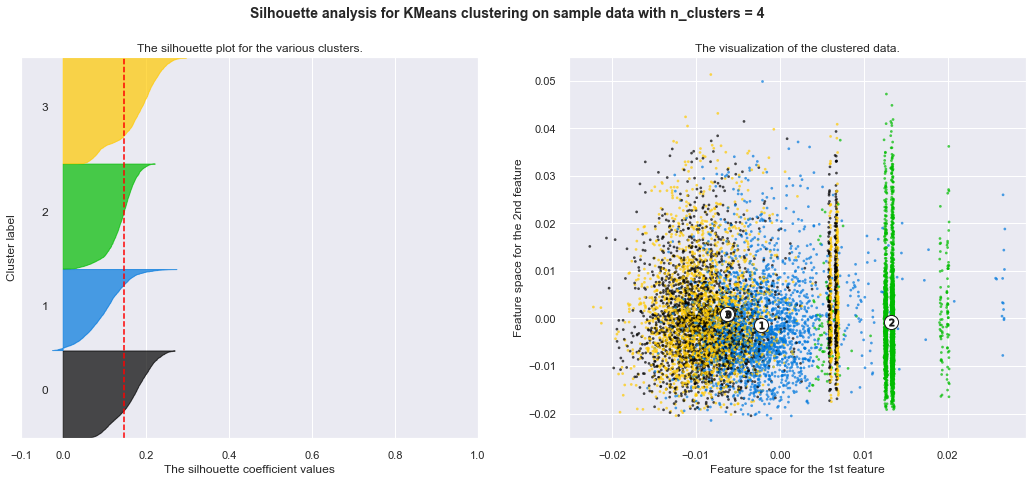

In [44]:
display_clusters(X_ICA,4)

For n_clusters = 3 The average silhouette_score is : 0.2653769051032642


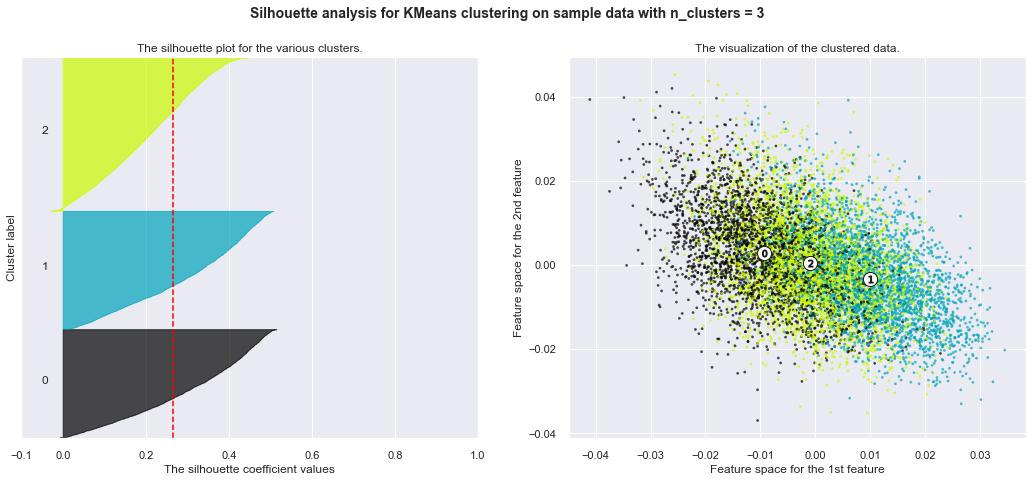

In [45]:
display_clusters(X_RP,3)